# Exploring 1D Interpolation in Python with SciPy and NumPy

Interpolation is the process of estimating unknown values that fall between known data points. In 1D interpolation, we have a set of known data points $(x_i, y_i)$ and we want to find a function $f(x)$ such that $f(x_i) = y_i$ for all $i$, and which we can use to estimate $y$ for any $x$ between the known $x_i$.

This is incredibly useful in many fields, including engineering, data science, and computer graphics, for tasks like:

* Resampling signals or time series.
* Smoothing data or curves.
* Filling in missing data points.
* Creating continuous functions from discrete measurements.

We will explore a range of algorithms, from simple linear interpolation to more sophisticated polynomial and spline methods, and discuss their strengths and weaknesses.

## 1. Setup: Importing Libraries

First, let's import the necessary libraries. We'll need `numpy` for numerical operations (especially creating arrays), `matplotlib.pyplot` for plotting our results, and various functions/classes from `scipy.interpolate`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import (
    interp1d,
    Akima1DInterpolator,
    BarycentricInterpolator,   barycentric_interpolate,
    KroghInterpolator,         krogh_interpolate,
    PchipInterpolator,         pchip_interpolate,
    CubicSpline,
    CubicHermiteSpline,
    PPoly,
    lagrange
)

np.set_printoptions(linewidth=200)

## 2. Sample Data Sets

To test our interpolation methods, we need some data. We'll create a few different datasets to highlight the characteristics of each algorithm.

1.  **Smooth Data**: A simple sine wave.
2.  **Sharp Change Data**: Data with a more abrupt change.
3.  **Runge Function Data**: Known to cause issues (oscillations) with high-degree polynomial interpolation, especially with equally spaced points.
4.  **Hermite Data**: Includes derivative (slope) information, needed for `CubicHermiteSpline`.

In [2]:
# --- Data Set 1: Smooth Data ---
x_smooth = np.linspace(0, 10, 10)
y_smooth = np.sin(x_smooth)
x_eval_smooth = np.linspace(0, 10, 100)

# --- Data Set 2: Sharp Change Data ---
#x_sharp = np.array([1, 2, 3,   4,   5, 5.5,   7,   8, 9, 9.5, 10])
#y_sharp = np.array([0, 0, 0, 0.5, 0.4, 1.2, 1.2, 0.1, 0, 0.3, 0.6])
#x_eval_sharp = np.linspace(0.75, 10.25, 150)
x_sharp = np.array([1, 2, 3,   4, 5, 6, 7])
y_sharp = np.array([0, 0, 0, 0.5, 1, 1, 1])
x_eval_sharp = np.linspace(1, 7, 150)

# --- Data Set 3: Runge Function Data ---
runge_func = lambda x : 1/(1 + 25*x**2)
x_runge = np.linspace(-1, 1, 11)
y_runge = runge_func(x_runge)
x_eval_runge = np.linspace(-1, 1, 200)

# --- Data Set 4: Hermite Data (Needs derivatives) ---
x_hermite = np.array([0, 1.1, 1.8, 3.2, 5])
y_hermite = np.array([0, 0.5, 0, 1, -1])
dydx_hermite = np.array([1, -1, 1, 0, 1]) # Slopes at each point
x_eval_hermite = np.linspace(0, 5, 100)

In [3]:
# --- Helper function for plotting ---
def plot_interpolation(x_known, y_known, x_eval, y_eval, title, true_func=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x_known, y_known, 'ro', label='Known Data Points', markersize=8)
    plt.plot(x_eval,  y_eval,  'b-', label='Interpolated Curve')
    if true_func:
        plt.plot(x_eval, true_func(x_eval), 'g--', label='True Function', alpha=0.7)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Helper function for comparison plotting ---
def plot_comparison(x_known, y_known, x_eval, methods_dict, title):
    plt.figure(figsize=(12, 8))
    plt.plot(x_known, y_known, 'ro', label='Known Data Points', markersize=10, zorder=10)

    for name, y_eval in methods_dict.items():
        plt.plot(x_eval, y_eval, label=name, alpha=0.8)

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.draw()

## 3. Simple Linear Interpolation: `numpy.interp`

This is the most basic form of interpolation, often sufficient for simple tasks. It connects known data points with straight lines.

* **Strengths**: Very fast, simple to understand and implement, guarantees no overshoots.
* **Weaknesses**: The result is not smooth (only C0 continuous - continuous in value, but not in slope), can be inaccurate if the underlying function is highly curved.

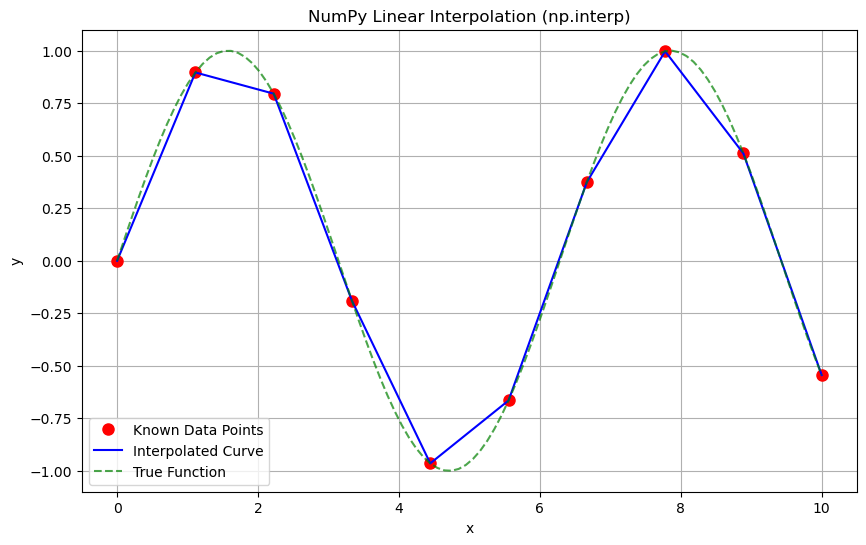

In [4]:
y_np_interp = np.interp(x_eval_smooth, x_smooth, y_smooth)

plot_interpolation(x_smooth, y_smooth, x_eval_smooth, y_np_interp,
                   'NumPy Linear Interpolation (np.interp)',
                   true_func=np.sin)

## 4. General 1D Interpolation: `scipy.interpolate.interp1d`

`interp1d` is a versatile function/class factory. It creates a function that can perform various kinds of interpolation:
* `linear`

`nearest-up` and `nearest` differ when interpolating half-integers (e.g. 0.5, 1.5) in that `nearest-up` rounds up and `nearest` rounds down:
* `nearest`
* `nearest-up`

`zero`, `slinear`, `quadratic` and `cubic` refer to a spline interpolation of zeroth, first, second or third order:
* `zero`
* `slinear`
* `quadratic`
* `cubic`

`previous` and `next` simply return the previous or next value of the point:
* `previous`
* `next`

While still widely used, SciPy often recommends using the newer object-oriented interpolators (like `CubicSpline`, `PchipInterpolator`, etc.) for new code, as they can be more flexible and sometimes faster.

* **Strengths**: Easy to use, offers multiple interpolation kinds (linear, cubic are common).
* **Weaknesses**: Can be slower than newer methods; higher-order options can lead to oscillations; considered somewhat 'legacy'.


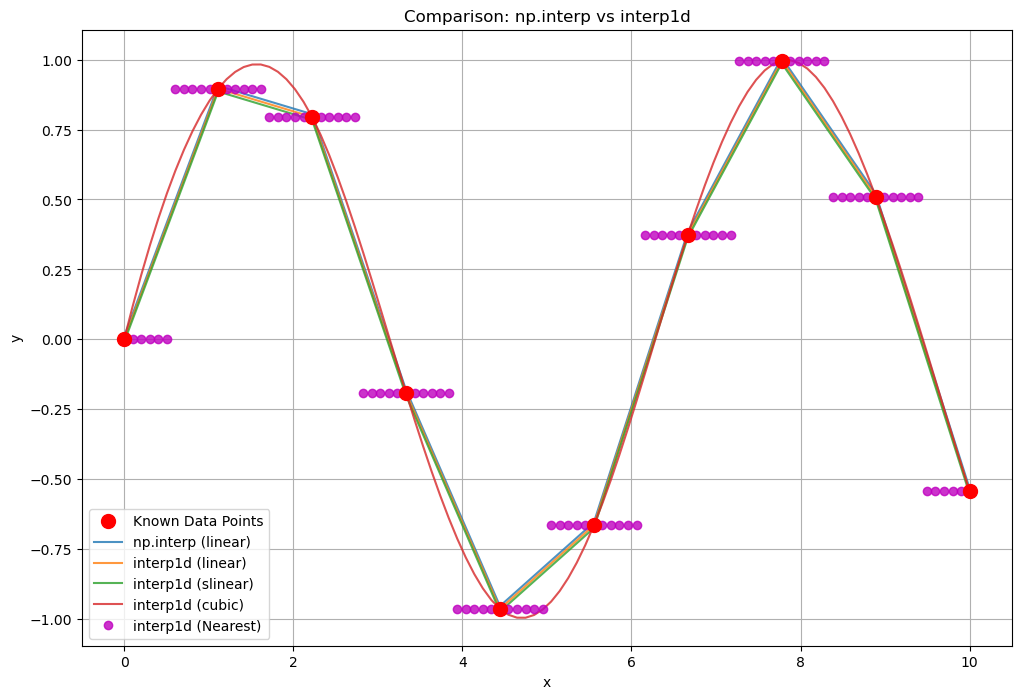

In [5]:
# --- Nearest ---
f_nearest = interp1d(x_smooth, y_smooth, kind='nearest')
y_interp1d_nearest = f_nearest(x_eval_smooth)

# --- Linear ---
f_linear = interp1d(x_smooth, y_smooth, kind='linear')
y_interp1d_linear = f_linear(x_eval_smooth)

f_slinear = interp1d(x_smooth, y_smooth, kind='slinear')
y_interp1d_slinear = f_slinear(x_eval_smooth)

# --- Cubic ---
f_cubic = interp1d(x_smooth, y_smooth, kind='cubic')
y_interp1d_cubic = f_cubic(x_eval_smooth)

# --- Comparison ---
comparison_dict = {
#   'interp1d (Nearest)': y_interp1d_nearest,
    'np.interp (linear)':  y_np_interp        + 0.01, # Add small offset for visibility
    'interp1d (linear)':   y_interp1d_linear,
    'interp1d (slinear)':  y_interp1d_slinear - 0.01, # Add small offset for visibility
    'interp1d (cubic)':    y_interp1d_cubic
}
plot_comparison(x_smooth, y_smooth, x_eval_smooth, comparison_dict,
                'Comparison: np.interp vs interp1d')

plt.plot(x_eval_smooth, y_interp1d_nearest, 'mo', label='interp1d (Nearest)', alpha=0.8)
plt.legend()
plt.show()

## 5. Piecewise Interpolators

To combat Runge's phenomenon and provide more control, piecewise interpolators are often preferred. They use *different*, usually low-degree (like cubic), polynomials between each pair of adjacent data points, and enforce certain continuity conditions where the pieces meet.

### `PchipInterpolator` (Piecewise Cubic Hermite Interpolating Polynomial)
**PCHIP** is a **shape-preserving** spline. Its primary goal is to avoid overshooting. If your data is monotonic (always increasing or always decreasing) between two points, the PCHIP interpolant will also be monotonic. This is incredibly useful for physical data like stress-strain curves or cumulative rainfall, where overshoots are nonsensical.

* **Strengths:**
    * **Preserves Monotonicity:** No overshoots. If the data doesn't wiggle, the curve won't either.
    * **Smooth ($C^1$):** The resulting curve has a continuous first derivative, so there are no "sharp corners."
    * Local behaviour.
* **Weaknesses:**
    * **Less "Smooth" than Cubic Spline:** The second derivative is discontinuous. This means the curvature can change abruptly at the data points, which might be visible as a slight lack of "roundness." It can look less 'smooth' than `CubicSpline`.

### `Akima1DInterpolator`
The Akima interpolator is another local method. Like PCHIP, it determines the slope at each data point using only a small "stencil" of neighboring points. It's known for producing curves that look very "natural," similar to how one might draw a curve by hand.

* **Strengths:**
    * **Resistant to Oscillations:** Effectively avoids wiggles.
    * **Local:** The value of the curve at a certain point is only affected by nearby data points, that is, the algorithm has a local behaviour.
    * **Smooth ($C^1$):** Like PCHIP, it has a continuous first derivative.
* **Weaknesses:**
    * **Discontinuous Second Derivative:** Similar to PCHIP, the curvature is not continuous.

This method has a variant `Makima`, that provides a middle ground between spline and PCHIP interpolation in terms of wiggle amplitude. In other words, it retains smoothness but with fewer unwanted oscillations compared to Akima. Compared to Makima, PCHIP tends to be more "aggressively flattened" near local extrema, which can make it less smooth in oscillatory data.

### `CubicSpline`
The most common spline, uses cubic polynomials and enforces C2 continuity (smooth value, slope, and curvature).

* **Strengths**: Very smooth (C2 continuous), generally accurate, supports boundary conditions.
* **Weaknesses**:


This is the "gold standard" of splines. It creates a piecewise cubic curve that is not only $C^1$ but also **$C^2$ continuous**. This means the function itself, its first derivative (slope), and its second derivative (related to curvature in mechanics) are all continuous. For physical models where smooth curvature is expected (like in the case of a deflected beam), this is often the most appropriate choice.

* **Strengths:**
    * **Very Smooth ($C^2$):** The continuous second derivative provides a visually pleasing and often physically realistic result.
    * Considered a great general-purpose interpolator for smooth data.
    * Supports boundary conditions.
* **Weaknesses:**
    * **Can exhibit overshoots/oscillations:** because it tries to minimize the overall curvature, it may introduce slight oscillations in regions of sharp change to maintain its smoothness, as we saw with `interp1d`. Use PCHIP if this is an issue.

### Functional Forms (`pchip_interpolate`)
Provides a one-shot function.

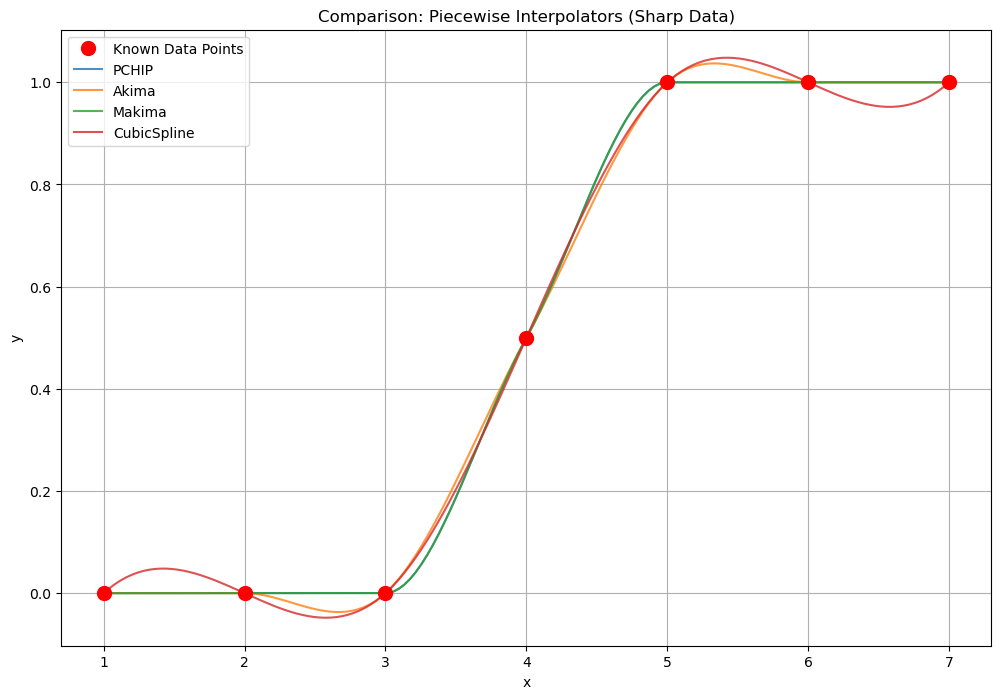

In [6]:
# --- Comparison (SHARP DATA) ---

# --- PCHIP ---
pchip_interpolator = PchipInterpolator(x_sharp, y_sharp)
y_pchip = pchip_interpolator(x_eval_sharp)

# --- Akima ---
akima_interpolator = Akima1DInterpolator(x_sharp, y_sharp, method='akima')
y_akima = akima_interpolator(x_eval_sharp)

# --- Makima ---
makima_interpolator = Akima1DInterpolator(x_sharp, y_sharp, method='makima')
y_makima = makima_interpolator(x_eval_sharp)

# --- CubicSpline (Default: Natural BC) ---
cubic_spline = CubicSpline(x_sharp, y_sharp)
y_cspline = cubic_spline(x_eval_sharp)

# --- Functional PCHIP ---
y_pchip_func = pchip_interpolate(x_sharp, y_sharp, x_eval_sharp)

# --- Comparison (Sharp Data) ---
comparison_dict = {
    'PCHIP':         y_pchip,
#   'PCHIP (Func)':  y_pchip_func + 0.01, # Add small offset for visibility
    'Akima':         y_akima,
    'Makima':        y_makima,
    'CubicSpline':   y_cspline,
}
plot_comparison(x_sharp, y_sharp, x_eval_sharp, comparison_dict,
                'Comparison: Piecewise Interpolators (Sharp Data)')

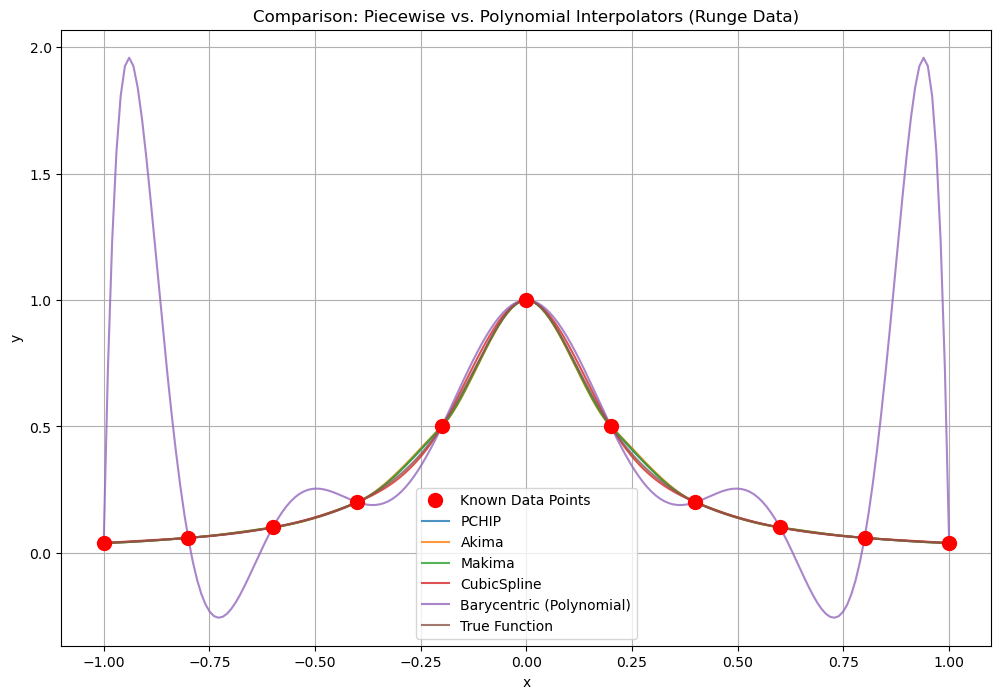

In [7]:
# --- Comparison (RUNGE DATA) ---

# --- PCHIP ---
pchip_interpolator = PchipInterpolator(x_runge, y_runge)
y_pchip = pchip_interpolator(x_eval_runge)

# --- Akima ---
akima_interpolator = Akima1DInterpolator(x_runge, y_runge, method='akima')
y_akima = akima_interpolator(x_eval_runge)

# --- Makima ---
makima_interpolator = Akima1DInterpolator(x_runge, y_runge, method='makima')
y_makima = makima_interpolator(x_eval_runge)

# --- CubicSpline (Default: Natural BC) ---
cubic_spline = CubicSpline(x_runge, y_runge)
y_cspline = cubic_spline(x_eval_runge)

# --- Barycentric ---
bary_poly = BarycentricInterpolator(x_runge, y_runge)
y_bary = bary_poly(x_eval_runge)

# --- Comparison (Runge Data) ---
comparison_dict = {
    'PCHIP':                    y_pchip,
    'Akima':                    y_akima,
    'Makima':                   y_makima,
    'CubicSpline':              y_cspline,
    'Barycentric (Polynomial)': y_bary,
    'True Function':            runge_func(x_eval_runge)
}
plot_comparison(x_runge, y_runge, x_eval_runge, comparison_dict,
                'Comparison: Piecewise vs. Polynomial Interpolators (Runge Data)')

In practice, the choice between PCHIP and Akima often comes down to aesthetic preference, as both are robust methods for preventing oscillations.

## 6. Hermite Interpolation: `CubicHermiteSpline`

Standard interpolation only uses the $y$-values. Hermite interpolation additionally uses the *derivative* (slope) $y'$ at each point. If you have this extra information, you can often achieve a much better fit.

* **Strengths**: Incorporates slope information for a more accurate fit, C1 continuous.
* **Weaknesses**: You must know the derivatives at each point, which is often not the case with simple experimental data.

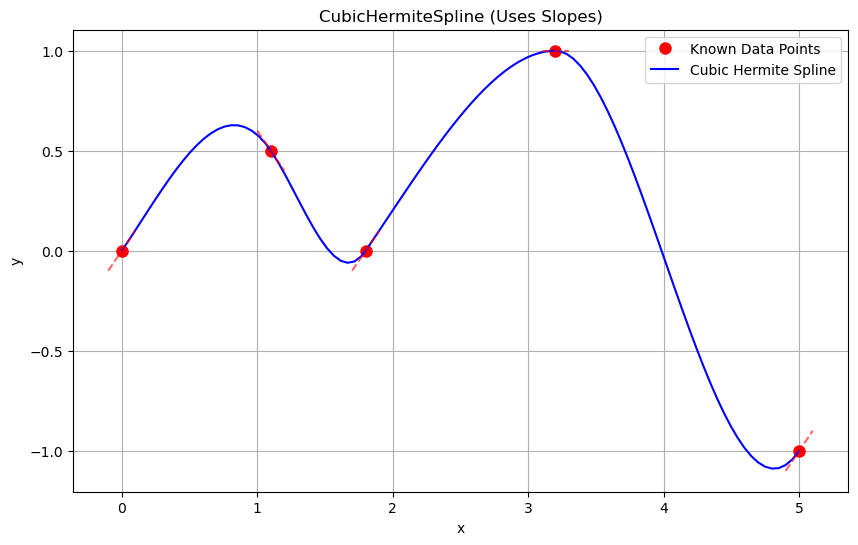

In [8]:
hermite_spline = CubicHermiteSpline(x_hermite, y_hermite, dydx_hermite)
y_chs = hermite_spline(x_eval_hermite)

# Plotting Hermite - adding slope indicators
plt.figure(figsize=(10, 6))
plt.plot(x_hermite, y_hermite,  'ro', label='Known Data Points', markersize=8)
plt.plot(x_eval_hermite, y_chs, 'b-', label='Cubic Hermite Spline')
# Plot slopes
for i in range(len(x_hermite)):
    dx = 0.1 # Small delta for plotting slope
    plt.plot([x_hermite[i]-dx, x_hermite[i]+dx],
             [y_hermite[i]-dx*dydx_hermite[i], y_hermite[i]+dx*dydx_hermite[i]],
             'r--', alpha=0.6, label='_nolegend_')

plt.title('CubicHermiteSpline (Uses Slopes)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## 7. Polynomial Representations: `PPoly` and `BPoly`

`PPoly` (Piecewise Polynomial) is not an interpolator itself, but a class used to *represent* piecewise polynomial functions. Many interpolators, like `CubicSpline`, return objects that *are* or *can be converted to* `PPoly` objects. You can also construct them directly if you know the coefficients and knots.

* **`PPoly` (Piecewise Polynomial in Power Basis):** This represents the polynomial on each interval using the familiar power series: $a + b(x-x_i) + c(x-x_i)^2 + ...$. This is what `CubicSpline` and `PchipInterpolator` return. It's efficient for evaluation.

You generally won't create these directly for interpolation, but it's good to know what they are when you inspect the output of a spline function.

We can inspect the output of `CubicSpline` to see its `PPoly` representation:

In [9]:
# Get the PPoly object from our CubicSpline
cspline_obj = CubicSpline(x_smooth, y_smooth)
print(f"CubicSpline object type: {type(cspline_obj)}")
print(f"It is a PPoly: {isinstance(cspline_obj, PPoly)}")
print(f"Knots (x_i):\n{cspline_obj.x}")
print(f"Coefficients (descending powers, per interval d, c, b, a):\n{cspline_obj.c}")

CubicSpline object type: <class 'scipy.interpolate._cubic.CubicSpline'>
It is a PPoly: True
Knots (x_i):
[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556  6.66666667  7.77777778  8.88888889 10.        ]
Coefficients (descending powers, per interval d, c, b, a):
[[-0.01821004 -0.01821004  0.17295221  0.12600829 -0.04937041 -0.17123088 -0.10868029  0.10065822  0.10065822]
 [-0.34315144 -0.40385156 -0.46455168  0.1119557   0.53198334  0.3674153  -0.20335429 -0.56562192 -0.2300945 ]
 [ 1.21033389  0.38033055 -0.58456194 -0.97633525 -0.26084743  0.73848439  0.9207744   0.06635639 -0.81777296]
 [ 0.          0.8961922   0.79522006 -0.19056796 -0.96431712 -0.66510151  0.37415123  0.99709789  0.51060568]]


## 8. A Grand Comparison: Exposing Strengths and Weaknesses

Theory is one thing, but seeing how these algorithms perform on challenging data is another. We will now run all our primary interpolation methods on two critical test cases.

1.  **An Abrupt Step:** This simulates a sudden change, like a rapid drop in groundwater level in a soil profile or a shear key in a structure. This type of function is notorious for inducing overshoots.
2.  **An Oscillating Signal:** This represents data with some inherent curvature and local extrema, like vibration data from a bridge or a non-uniform temperature distribution. This will expose the instability of high-degree polynomials.

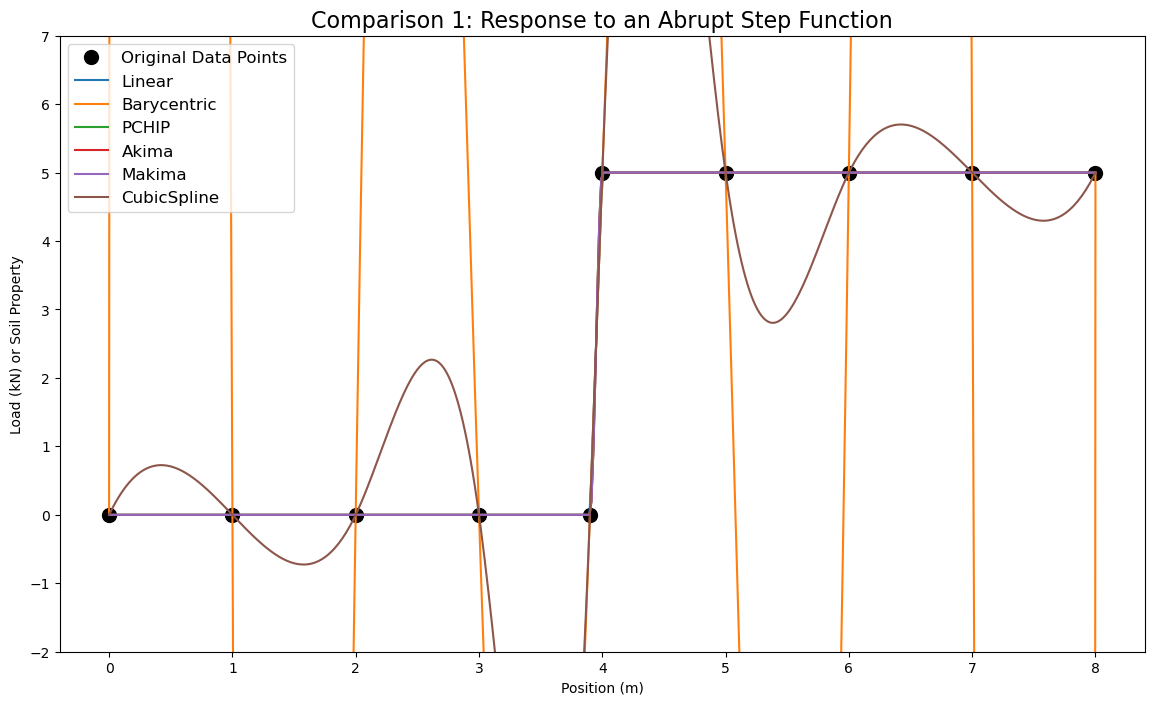

In [10]:
# Define our list of interpolators to compare
# We will use lambdas to make them all callable with the same signature
interpolators = {
    'Linear':      lambda x, y: interp1d(x, y, kind='linear'),
    'Barycentric': lambda x, y: BarycentricInterpolator(x, y),
    'PCHIP':       lambda x, y: PchipInterpolator(x, y),
    'Akima':       lambda x, y: Akima1DInterpolator(x, y, method='akima'),
    'Makima':      lambda x, y: Akima1DInterpolator(x, y, method='makima'),
    'CubicSpline': lambda x, y: CubicSpline(x, y)
}

# --- TEST CASE 1: The Abrupt Step ---
x_step = np.array([0, 1, 2, 3, 3.9, 4, 5, 6, 7, 8])
y_step = np.array([0, 0, 0, 0,   0, 5, 5, 5, 5, 5])
x_fine_step = np.linspace(0, 8, 500)

plt.figure(figsize=(14, 8))
plt.plot(x_step, y_step, 'o', markersize=10, label='Original Data Points', color='black')

for name, interp_func_generator in interpolators.items():
    # Create the interpolator object/function
    interpolator = interp_func_generator(x_step, y_step)
    y_fine = interpolator(x_fine_step)
    plt.plot(x_fine_step, y_fine, label=name)

plt.title('Comparison 1: Response to an Abrupt Step Function', fontsize=16)
plt.xlabel('Position (m)')
plt.ylabel('Load (kN) or Soil Property')
plt.ylim(-2, 7) # Zoom in to see the overshoots clearly
plt.legend(fontsize=12)
plt.show()

#### Comparison 1: Response to an Abrupt Step

This plot is incredibly revealing.

* **Overshooting clearly visible:** Look at the `CubicSpline` and `interp1d (cubic)` curves. Before the jump at x=4, they dip into negative values, and after the jump, they overshoot the value of 5. This is a direct consequence of their attempt to maintain a smooth second derivative ($C^2$ continuity). They "anticipate" the turn and swing too far.
* **Shape-Preserving Success:** `PCHIP` and `Akima` are the heroes here. They pass through all points and, critically, do not oscillate. They remain flat where the data is flat. This is precisely why they are recommended for data where monotonicity is important.
* **The Catastrophe of High-Degree Polynomials:** The `Krogh` interpolator creates a polynomial of degree 9 to fit the 10 data points. The result is a series of enormous, physically meaningless oscillations. It demonstrates perfectly why this method should not be used for this kind of data.
* **The Simplicity of Linear:** `Linear` interpolation does exactly what's expected: it creates a straight, sharp line connecting the points around the step. It's not smooth, but it's predictable and stable.

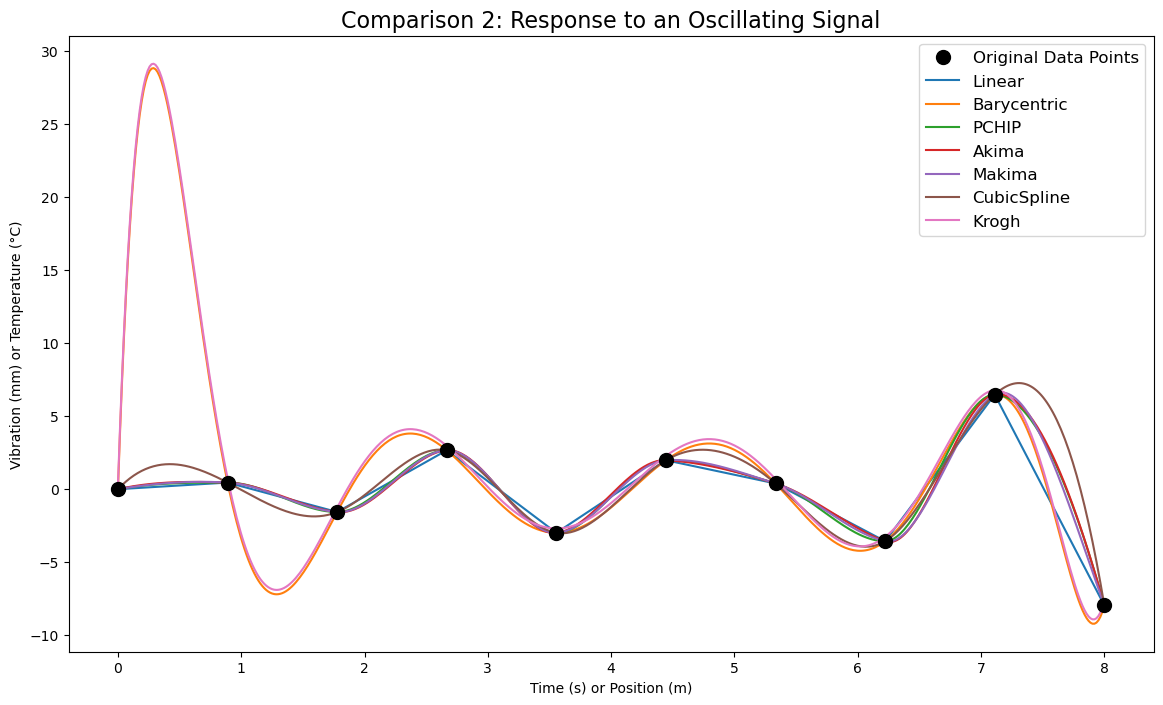

In [11]:
# --- TEST CASE 2: The Oscillating Signal ---
x_osc = np.linspace(0, 8, 10)
y_osc = x_osc*np.sin(10*x_osc) # A simple sine wave
x_fine_osc = np.linspace(0, 8, 500)

plt.figure(figsize=(14, 8))
plt.plot(x_osc, y_osc, 'o', markersize=10, label='Original Data Points', color='black', zorder=10)

# We will add Krogh here to show it's the same as Barycentric
interpolators_osc = interpolators.copy()
interpolators_osc['Krogh'] = lambda x, y: KroghInterpolator(x,y)

for name, interp_func_generator in interpolators_osc.items():
    interpolator = interp_func_generator(x_osc, y_osc)
    if name == 'Krogh':
        y_fine = interpolator(x_fine_osc) + 0.3 # add a small offset for visibility
    else:
        y_fine = interpolator(x_fine_osc)        
    plt.plot(x_fine_osc, y_fine, label=name)

plt.title('Comparison 2: Response to an Oscillating Signal', fontsize=16)
plt.xlabel('Time (s) or Position (m)')
plt.ylabel('Vibration (mm) or Temperature (°C)')
#plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.show()

#### Comparison 2: Response to an Oscillating Signal

This plot shows the danger of using the wrong tool for what seems like simple, smooth data.

* **Total Failure of `Krogh` and `Barycentric`:** As you can see, the dashed lines for `Krogh` and `Barycentric` suffer of wild oscillations. This is Runge's phenomenon in action. Even on this smooth sine wave, the high-degree polynomial becomes unstable near the edges of the domain. This is an immediate disqualification for real-world use.
* **The Splines Behave Well:** All the spline-based methods (`CubicSpline`, `PCHIP`, `Akima`) provide excellent, stable, and visually indistinguishable approximations to the underlying sine function. On "well-behaved" data like this, they are all fantastic choices.
* **Linear as a Baseline:** The `Linear` method provides a reasonable but visibly angular approximation. The splines are clearly superior in capturing the smooth curvature of the sine function.

These direct comparisons provide the definitive visual proof of the concepts we've discussed. When in doubt, a robust, shape-preserving spline like **`PchipInterpolator`** is often your safest and most reliable choice.

## 9. Comparison and Summary

Choosing the right interpolation algorithm depends heavily on your data and your goals.

| Algorithm | Type | Continuity | Overshoots? | Strengths | Weaknesses | Best For |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| `np.interp` | Piecewise Linear | C0 | No | Very fast, simple | Not smooth, low accuracy | Quick & dirty, performance-critical linear needs |
| `interp1d(linear)` | Piecewise Linear | C0 | No | Simple interface | Not smooth, 'legacy' | Simple linear tasks |
| `interp1d(cubic)` | Piecewise Cubic | C1 (approx) | Yes | Simple interface | Can overshoot, 'legacy' | Quick smooth curves (but `CubicSpline` is better) |
| `Krogh` | Global Polynomial | Cn | Very Likely | Handles derivatives | **Runge's phenomenon** | Known polynomial data, derivative use |
| `Barycentric` | Global Polynomial | Cn | Very Likely | Numerically stable | **Runge's phenomenon** | Evaluating *the* interpolating polynomial efficiently |
| `Pchip` | Piecewise Cubic | C1 | **No** | **Shape-preserving**, good for monotone data | Only C1 smooth | Data with sharp changes, avoiding overshoots |
| `Akima` | Piecewise Cubic | C1 | Less Likely | Local behaviour, "natural look" | Only C1 smooth | Data with sharp changes, visual appeal |
| `CubicSpline` | Piecewise Cubic | **C2** | Possible | **Very smooth**, flexible BCs | Can overshoot | General-purpose smooth interpolation |
| `CubicHermite` | Piecewise Cubic | C1 | Depends | Uses slopes for accuracy | **Needs slopes** | When derivative data is available |

**Key Takeaways:**

* For general-purpose, smooth interpolation, `CubicSpline` is often a great starting point.
* If you encounter overshoots or need to preserve the shape (monotonicity) of your data, use `PchipInterpolator`.
* Avoid global polynomial interpolators (`Krogh`, `Barycentric`) for a large number of equally spaced points unless you know the data is well-suited or you use specific techniques (like Chebyshev nodes, not covered here) to mitigate Runge's phenomenon.
* If speed is absolutely critical for simple linear tasks, `np.interp` is hard to beat.
* If you have derivative data, `CubicHermiteSpline` can provide superior results.

## Homework

1. Illustrate the following methods of the interpolating classes:

* `derivative()`
* `antiderivative()`
* `integrate()`
* `roots()`

2. Illustrate the use of the `periodic` boundary condition in the cubic spline.
